# EE219 Project 1

Team members:  
Yichen Wu 504294181  
Siyuan Chen 405024391

### Required Packages:
nltk v3.2.5  
numpy v1.14.0  
scikit-learn v0.19.1  
scipy 1.0.0  
matplotlib v2.1.2  

In [23]:
import string
from sklearn.feature_extraction.text import *
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import NMF, TruncatedSVD
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import numpy as np
import itertools

'''
try:
    nltk.download("stopwords")  # if the host does not have the package
except (RuntimeError):
    pass
'''

# globals
MIN_DF = 2


class SparseToDenseArray(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def transform(self, X, *_):
        if hasattr(X, 'toarray'):
            return X.toarray()
        return X

    def fit(self, *_):
        return self


def stem_and_tokenize(doc):
    exclude = set(string.punctuation)
    no_punctuation = ''.join(ch for ch in doc if ch not in exclude)
    tokenizer = RegexpTokenizer("[\w']+")
    tokens = tokenizer.tokenize(no_punctuation)
    stemmer = SnowballStemmer("english", ignore_stopwords=True)
    return [stemmer.stem(t) for t in tokens]

tfidf_transformer = TfidfTransformer(sublinear_tf=True, smooth_idf=False, use_idf=True)


def doTFIDF(data, mindf):
    vectorizer = CountVectorizer(min_df=mindf, stop_words=ENGLISH_STOP_WORDS, tokenizer=stem_and_tokenize)
    m = vectorizer.fit_transform(data)
    m_train_tfidf = tfidf_transformer.fit_transform(m)
    return m_train_tfidf


def analyze(label, prob, predict, classes, n):
    if n <= 2:
        fpr, tpr, thresholds = roc_curve(label, prob)
        roc_auc = auc(fpr,tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='lightsteelblue',
                 lw=2, label='AUC (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='deeppink', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()

    cmatrix = confusion_matrix(label, predict)
    plt.imshow(cmatrix, interpolation='nearest', cmap=plt.cm.BuGn)
    plt.title("Confusion Matrix")
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=25)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cmatrix.max() / 2.
    for i, j in itertools.product(range(n), range(n)):
        plt.text(j, i, format(cmatrix[i, j], fmt),
                horizontalalignment="center",
                color="white" if cmatrix[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

    print("accuracy: ", accuracy_score(label, predict))
    if n <= 2:
        print("recall: ", recall_score(label, predict))
        print("precision: ", precision_score(label, predict))
    else:
        print("recall: ", recall_score(label, predict, average='weighted'))
        print("precision: ", precision_score(label, predict, average='weighted'))
    return


This part is to load data and import the library that we need for this project.

In [2]:
# load data from 20 news group

import numpy as np
import logging
from logging.config import fileConfig
from sklearn.datasets import fetch_20newsgroups

# create logger
fileConfig('logging_config.ini')
logger = logging.getLogger()
logger.setLevel("WARNING")

categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware',
              'comp.sys.mac.hardware', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']

cat_comp = categories[:4]   # Computer Technologies
cat_rec = categories[4:]    # Recreational Activities
CAT = ["Computer Technologies", "Recreational Activities"]

logging.info("loading data")
# all_data = fetch_20newsgroups(subset='all', categories=categories, shuffle=True, random_state=42)

train_data = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)
test_data = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

# create labels
# 0 for computer technology, 1 for recreational activities
train_label = [(x//4) for x in train_data.target]
test_label = [(x//4) for x in test_data.target]
'''
comp_data_test = fetch_20newsgroups(subset='test', categories=cat_comp, shuffle=True, random_state=42)
comp_data_train = fetch_20newsgroups(subset='train', categories=cat_comp, shuffle=True, random_state=42)
rec_data_test = fetch_20newsgroups(subset='test', categories=cat_rec, shuffle=True, random_state=42)
rec_data_train = fetch_20newsgroups(subset='train', categories=cat_rec, shuffle=True, random_state=42)
'''

logging.info("loading finished")



#### a) Plot a histogram of the number of training documents per class

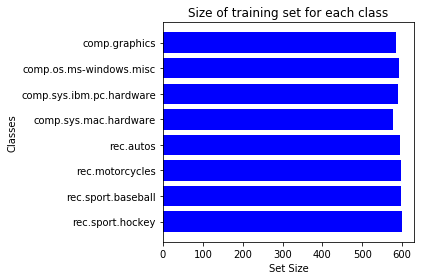

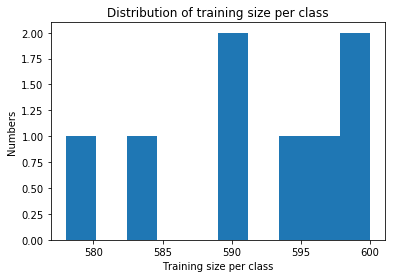

In [3]:
import numpy as np
import pylab as pl

logging.info("Problem a")

cat_sum_train = []          # training data size of each class 0-7
cat_sum_test = []           # testing data size of each class 0-7

for i in range(len(categories)):
    temp = fetch_20newsgroups(subset='train', categories=[categories[i]], shuffle=True, random_state=42)
    cat_sum_train.append(len(temp.data))
    temp = fetch_20newsgroups(subset='test', categories=[categories[i]], shuffle=True, random_state=42)
    cat_sum_test.append(len(temp.data))

y_pos = np.arange(len(categories))
pl.figure(1)
pl.barh(y_pos, cat_sum_train, align='center', color='blue', ecolor='black')
pl.xlabel("Set Size")
pl.ylabel("Classes")
pl.title("Size of training set for each class")
pl.yticks(y_pos, categories)
pl.gca().invert_yaxis()
pl.tight_layout()

pl.figure(2)
pl.hist(cat_sum_train)
pl.title("Distribution of training size per class")
pl.xlabel("Training size per class")
pl.ylabel("Numbers")
pl.show()

logging.info("finished Problem a")


We've plotted the bar chart and histogram of number of training documents per training class. From the bar chart, we can see that the data are not exactly evenly distributed but with very small difference.So no further processing is necessary.

#### b) TFxIDF

In [4]:
from timeit import default_timer as timer

logging.info("Problem b")
start = timer()
X_train_tfidf = doTFIDF(train_data.data, MIN_DF)
print("With min_df = %d , (training documents, terms extracted): " % MIN_DF, X_train_tfidf.shape)

X5_train_tfidf = doTFIDF(train_data.data, 5)
print("With min_df = 5 , (training documents, terms extracted): ", X5_train_tfidf.shape)

duration = timer() - start
logging.debug("Computation Time in secs: %d" % duration)
logging.info("finished Problem b")


With min_df = 2 , (training documents, terms extracted):  (4732, 21895)
With min_df = 5 , (training documents, terms extracted):  (4732, 8892)


#### c) Top 10 significant terms for selected classes

In [22]:
logging.info("Problem c")

logging.info("loading training data")
all_class_data = fetch_20newsgroups(subset='all', shuffle=True, random_state=42)

logging.info("concatenating data")
string_of_each_class = []
for i in range(len(all_class_data.target_names)):
    string_of_each_class.append("")

for i in range(len(all_class_data.data)):
    string_of_each_class[all_class_data.target[i]] = string_of_each_class[all_class_data.target[i]]\
                                                     + " " + all_class_data.data[i]

logging.info("vectorizing")
# tfidf_vectorizer = TfidfVectorizer(min_df=MIN_DF, analyzer="word", stop_words=ENGLISH_STOP_WORDS,
#                                   sublinear_tf=True, use_idf=True,
#                                   tokenizer=stem_and_tokenize)

vectorizer = CountVectorizer(min_df=MIN_DF, analyzer="word", stop_words=ENGLISH_STOP_WORDS, tokenizer=stem_and_tokenize)
M = vectorizer.fit_transform(string_of_each_class)
M_train_tficf = tfidf_transformer.fit_transform(M)
print("With min_df = %d, (all classes, terms extracted): " % MIN_DF, M_train_tficf.shape)


cat_top10 = ["comp.sys.ibm.pc.hardware", "comp.sys.mac.hardware", "misc.forsale", "soc.religion.christian"]

for name in cat_top10:
    index = all_class_data.target_names.index(name)
    arr = M_train_tficf.toarray()[index]
    sig_terms = np.argsort(arr)[-10:][-1::-1]
    print("Top 10 most significant terms in class %s are:" % name)
    for i in sig_terms:
        print(vectorizer.get_feature_names()[i])
    print()
    
    '''  debugging block
    print(arr[sig_terms])
    chrisid = vectorizer.get_feature_names().index('mac')
    print(chrisid)
    print("value for christ is %f: " % arr[chrisid])
    '''
print("-" * 70)
    
vectorizer5 = CountVectorizer(min_df=MIN_DF, analyzer="word", stop_words=ENGLISH_STOP_WORDS, tokenizer=stem_and_tokenize)
M5 = vectorizer5.fit_transform(string_of_each_class)
M5_train_tficf = tfidf_transformer.fit_transform(M5)
print("With min_df = 5, (all classes, terms extracted): ", M5_train_tficf.shape)

    
for name in cat_top10:
    index = all_class_data.target_names.index(name)
    arr = M5_train_tficf.toarray()[index]
    sig_terms = np.argsort(arr)[-10:][-1::-1]
    print("Top 10 most significant terms in class %s are:" % name)
    for i in sig_terms:
        print(vectorizer5.get_feature_names()[i])
    print()
    
    
logging.info("finished Problem c")


With min_df = 2, (all classes, terms extracted):  (20, 31410)
Top 10 most significant terms in class comp.sys.ibm.pc.hardware are:
scsi1
adaptec
scsi2
com4
scsi
guydaustinibmcom
ide
nanao
hoskyn
dx2

Top 10 most significant terms in class comp.sys.mac.hardware are:
quadra
pds
centri
nubus
powerbook
iisi
performa
duo
iivx
powerpc

Top 10 most significant terms in class misc.forsale are:
wolverin
hobgoblin
pom
hulk
obo
forsal
lobo
superman
sega
070

Top 10 most significant terms in class soc.religion.christian are:
boswel
byler
psalm
apostl
leviticus
siemon
jayn
bestial
consecr
baptiz

----------------------------------------------------------------------
With min_df = 5, (all classes, terms extracted):  (20, 31410)
Top 10 most significant terms in class comp.sys.ibm.pc.hardware are:
scsi1
adaptec
scsi2
com4
scsi
guydaustinibmcom
ide
nanao
hoskyn
dx2

Top 10 most significant terms in class comp.sys.mac.hardware are:
quadra
pds
centri
nubus
powerbook
iisi
performa
duo
iivx
powerpc

Top 10

#### d) Apply LSI and NMF

In [6]:
logging.info("Problem d")

X_train_tfidf = doTFIDF(train_data.data, MIN_DF)
X_test_tfidf = doTFIDF(test_data.data, MIN_DF)

logging.info("SVD")
svd = TruncatedSVD(n_components=50, n_iter=10, random_state=17)
X_train_tfidf_LSI = svd.fit_transform(X_train_tfidf)
X_test_tfidf_LSI = svd.fit_transform(X_test_tfidf)

logging.info("NMF")
nmf = NMF(n_components=50, random_state=17)
X_train_tfidf_NMF= nmf.fit_transform(X_train_tfidf)
X_test_tfidf_NMF = nmf.fit_transform(X_test_tfidf)

logging.info("finished Problem d")


#### e) Try hard and soft SVC

----------------------------------------------------------------------
Using Min_df = 2  and gamma = 1000.000000


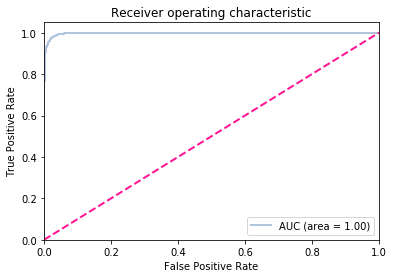

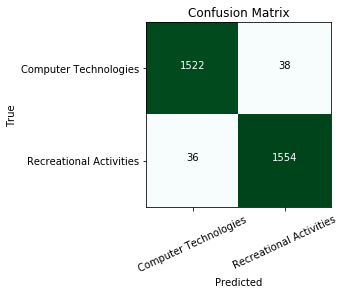

accuracy:  0.976507936508
recall:  0.977358490566
precision:  0.976130653266
----------------------------------------------------------------------
Using Min_df = 2  and gamma = 0.001000


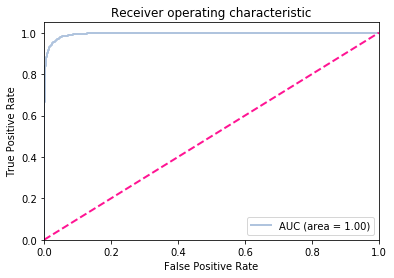

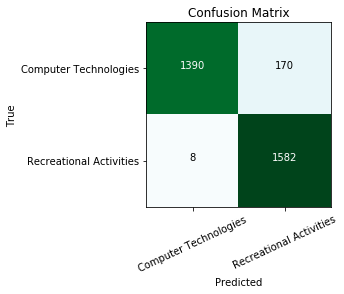

accuracy:  0.943492063492
recall:  0.994968553459
precision:  0.90296803653
----------------------------------------------------------------------
Using Min_df = 5  and gamma = 1000.000000


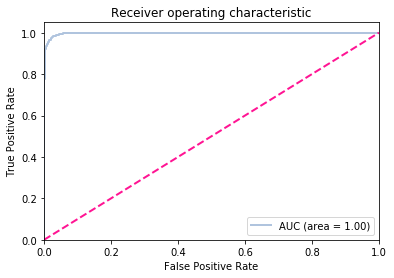

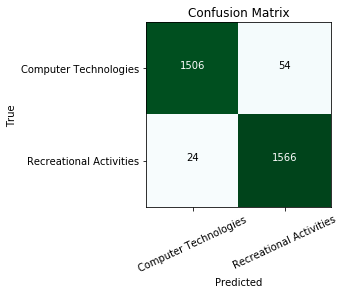

accuracy:  0.975238095238
recall:  0.984905660377
precision:  0.966666666667
----------------------------------------------------------------------
Using Min_df = 5  and gamma = 0.001000


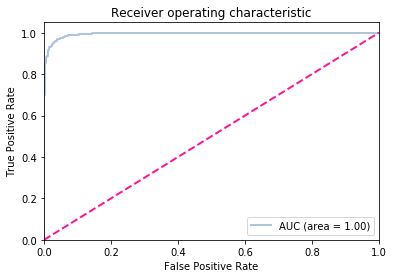

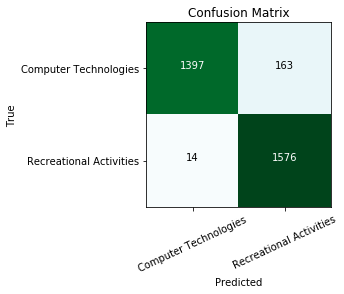

accuracy:  0.94380952381
recall:  0.991194968553
precision:  0.906267970098
Now compare NMF and LSI
----------------------------------------------------------------------
Using min_df=2 (fixed from now on), LSI ,and gamma = 1000.000000


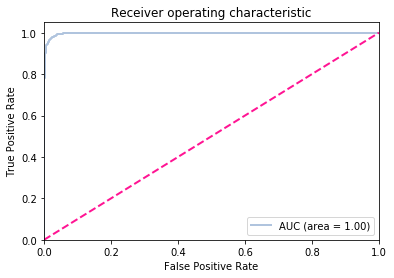

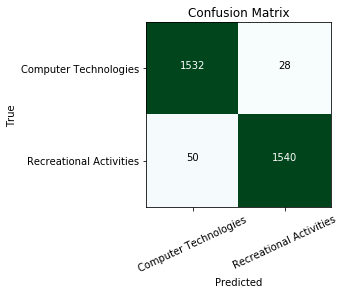

accuracy:  0.975238095238
recall:  0.968553459119
precision:  0.982142857143
----------------------------------------------------------------------
Using min_df=2 (fixed from now on), LSI ,and gamma = 0.001000


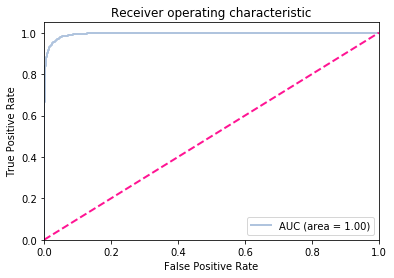

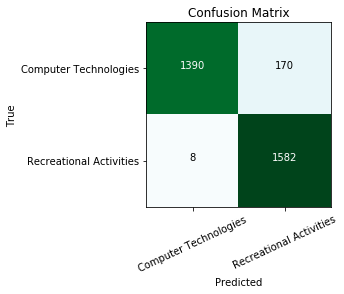

accuracy:  0.943492063492
recall:  0.994968553459
precision:  0.90296803653
----------------------------------------------------------------------
Using min_df=2 (fixed from now on), NMF ,and gamma = 1000.000000


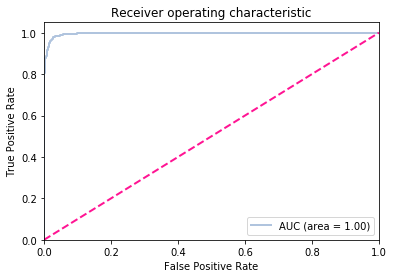

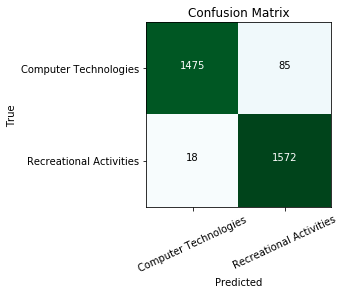

accuracy:  0.967301587302
recall:  0.988679245283
precision:  0.948702474351
----------------------------------------------------------------------
Using min_df=2 (fixed from now on), NMF ,and gamma = 0.001000


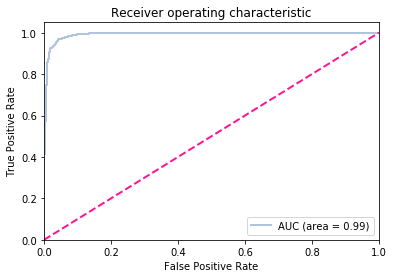

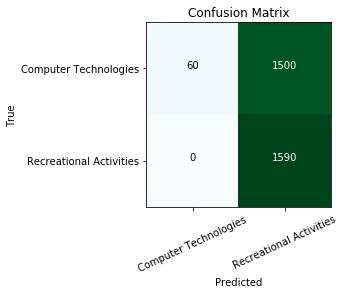

accuracy:  0.52380952381
recall:  1.0
precision:  0.514563106796


In [7]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

logging.info("Problem e")

# compare the effect of min_df with LSI only
min_df_arr = [MIN_DF, 5]
gamma = [1000, 0.001]
for ai, mdf in enumerate(min_df_arr):
    for bi, g in enumerate(gamma):
        pipeline_lsi = Pipeline([
            ('vect', CountVectorizer(min_df=mdf, stop_words=ENGLISH_STOP_WORDS, tokenizer=stem_and_tokenize)),
            ('tfidf', TfidfTransformer()),
            ('reduce_dim', TruncatedSVD(n_components=50, n_iter=10, random_state=17)),
            ('clf', LinearSVC(C=g)),
        ])
        pipeline_lsi.fit(train_data.data, train_label)
        pred_test = pipeline_lsi.predict(test_data.data)
        pred_test_prob = pipeline_lsi.decision_function(test_data.data)
        print("-" * 70)
        print("Using Min_df = %d" % mdf," and gamma = %f" % g)
        analyze(test_label, pred_test_prob, pred_test, CAT, 2)

print("Now compare NMF and LSI")
method_arr = [TruncatedSVD(n_components=50, n_iter=10, random_state=17),
              NMF(n_components=50, random_state=17)]
method_name = ["LSI", "NMF"]

for ai, method in enumerate(method_arr):
    for bi, g in enumerate(gamma):
        pipeline_e = Pipeline([
            ('vect', CountVectorizer(min_df=MIN_DF, stop_words=ENGLISH_STOP_WORDS, tokenizer=stem_and_tokenize)),
            ('tfidf', TfidfTransformer()),
            ('reduce_dim', method),
            ('clf', LinearSVC(C=g)),
        ])
        pipeline_e.fit(train_data.data, train_label)
        pred_test = pipeline_e.predict(test_data.data)
        pred_test_prob = pipeline_e.decision_function(test_data.data)
        print("-" * 70)
        print("Using min_df=2 (fixed from now on), " + method_name[ai] +
              " ,and gamma = %f" % g)
        analyze(test_label, pred_test_prob, pred_test, CAT, 2)

logging.info("finished Problem e")


#### f) Find best gamma with cross validation

Using method LSI


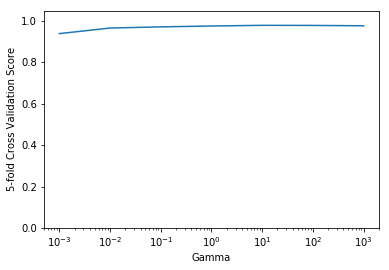

Best value for gamma:  10
----------------------------------------------------------------------
Using method LSI and best gamma 10.000000


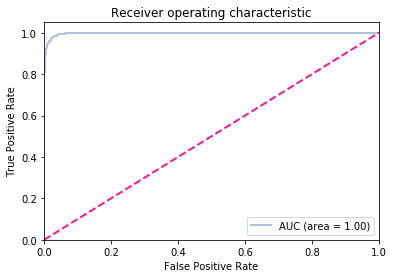

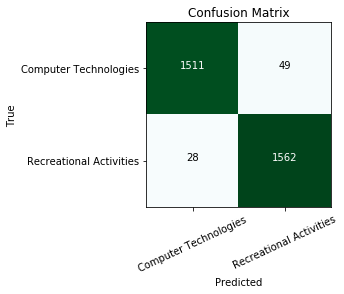

accuracy:  0.975555555556
recall:  0.982389937107
precision:  0.969584109249
----------------------------------------------------------------------
Using method NMF


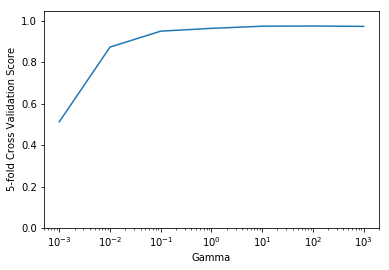

Best value for gamma:  100
----------------------------------------------------------------------
Using method NMF and best gamma 100.000000


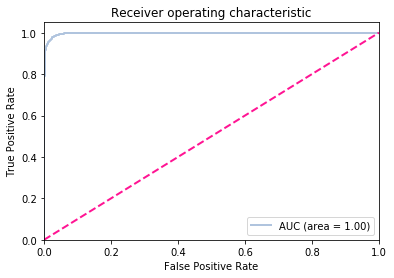

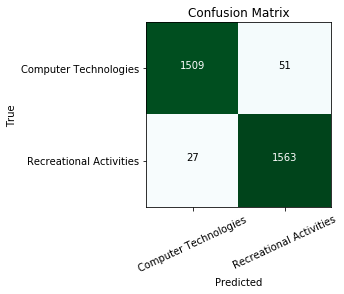

accuracy:  0.975238095238
recall:  0.983018867925
precision:  0.968401486989
----------------------------------------------------------------------


In [8]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

logging.info("Problem f")

gamma = [1000, 100, 10, 1, 0.1, 0.01, 0.001]

method_arr = [TruncatedSVD(n_components=50, n_iter=10, random_state=17),
              NMF(n_components=50, random_state=17)]
method_name = ["LSI", "NMF"]

train_reduced = []
test_reduced = []

for method in method_arr:
    pipeline_f = Pipeline([
        ('vect', CountVectorizer(min_df=MIN_DF, stop_words=ENGLISH_STOP_WORDS, tokenizer=stem_and_tokenize)),
        ('tfidf', TfidfTransformer()),
        ('reduce_dim', method),
    ])
    train_reduced.append(pipeline_f.fit_transform(train_data.data))
    test_reduced.append(pipeline_f.fit_transform(test_data.data))


best_g = []
for ai, method in enumerate(method_name):
    print("Using method "+method)
    Score = []
    for g in gamma:
        Score.append(np.average(cross_val_score(LinearSVC(C=g), train_reduced[ai], train_label, cv=5, n_jobs=-1)))
    plt.figure()
    plt.xlabel("Gamma")
    plt.ylabel('5-fold Cross Validation Score')
    plt.ylim([0.0, 1.05])
    plt.xscale('log')
    plt.plot(gamma, Score)
    plt.show()
    best_g.append(gamma[np.argmax(Score)])
    print("Best value for gamma: ", best_g[ai])

    pipeline_f = Pipeline([
        ('vect', CountVectorizer(min_df=mdf, stop_words=ENGLISH_STOP_WORDS, tokenizer=stem_and_tokenize)),
        ('tfidf', TfidfTransformer()),
        ('reduce_dim', TruncatedSVD(n_components=50, n_iter=10, random_state=17)),
        ('clf', LinearSVC(C=best_g[ai])),
    ])
    pipeline_f.fit(train_data.data, train_label)
    pred_test = pipeline_f.predict(test_data.data)
    pred_test_prob = pipeline_f.decision_function(test_data.data)
    print("-" * 70)
    print("Using method "+method+" and best gamma %f" % best_g[ai])
    analyze(test_label, pred_test_prob, pred_test, CAT, 2)
    print("-" * 70)


logging.info("finished Problem f")


#### g) Use naive Bayes algorithm

----------------------------------------------------------------------
Using LSI and Gaussian Naive Bayes


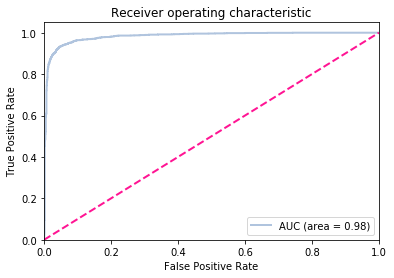

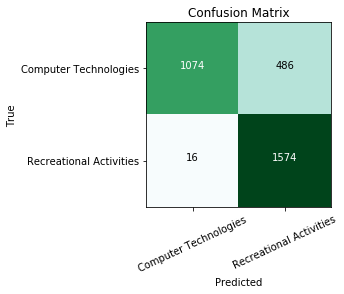

accuracy:  0.840634920635
recall:  0.989937106918
precision:  0.764077669903
----------------------------------------------------------------------
Using NMF and Gaussian Naive Bayes


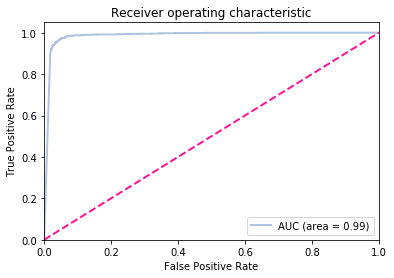

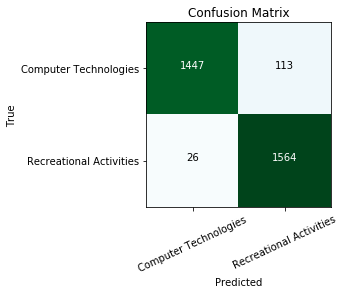

accuracy:  0.955873015873
recall:  0.983647798742
precision:  0.932617769827
----------------------------------------------------------------------
Using NVM and Multinomial Naive Bayes


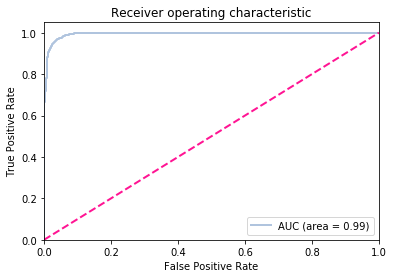

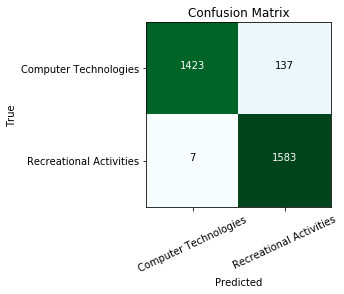

accuracy:  0.954285714286
recall:  0.995597484277
precision:  0.920348837209


In [11]:
logging.info("Problem g")
for ai, method in enumerate(method_arr):
    pipeline_g = Pipeline([
        ('vect', CountVectorizer(min_df=MIN_DF, stop_words=ENGLISH_STOP_WORDS, tokenizer=stem_and_tokenize)),
        ('tfidf', TfidfTransformer()),
        ('reduce_dim', method),
        ('clf', GaussianNB()),
    ])
    pipeline_g.fit(train_data.data, train_label)
    pred_test = pipeline_g.predict(test_data.data)
    pred_test_prob = pipeline_g.predict_proba(test_data.data)[:,1]
    print("-" * 70)
    print("Using " + method_name[ai] +
          " and Gaussian Naive Bayes")
    analyze(test_label, pred_test_prob, pred_test, CAT, 2)

pipeline_g2 = Pipeline([
    ('vect', CountVectorizer(min_df=MIN_DF, stop_words=ENGLISH_STOP_WORDS, tokenizer=stem_and_tokenize)),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', method_arr[1]),
    ('clf', MultinomialNB()),
])
pipeline_g2.fit(train_data.data, train_label)
pred_test = pipeline_g2.predict(test_data.data)
pred_test_prob = pipeline_g2.predict_proba(test_data.data)[:,1]
print("-" * 70)
print("Using NVM and Multinomial Naive Bayes")
analyze(test_label, pred_test_prob, pred_test, CAT, 2)

logging.info("finished Problem g")

#### h) Use logarithmic regression

----------------------------------------------------------------------
Using LSI and Logistic Regression withuot regularization


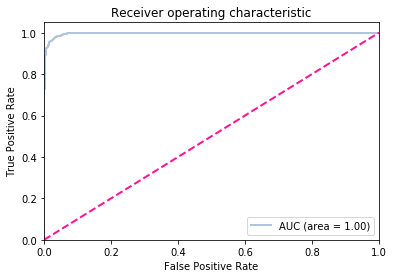

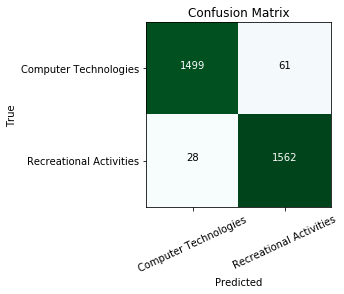

accuracy:  0.971746031746
recall:  0.982389937107
precision:  0.962415280345
----------------------------------------------------------------------
Using NMF and Logistic Regression withuot regularization


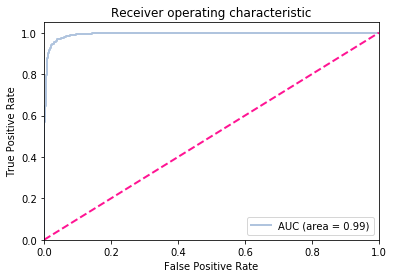

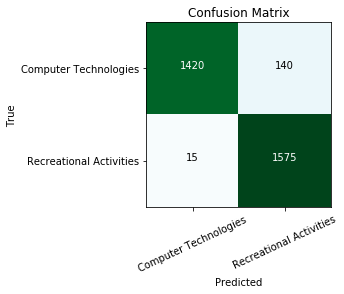

accuracy:  0.950793650794
recall:  0.990566037736
precision:  0.918367346939


In [12]:
from sklearn.linear_model import LogisticRegression

logging.info("Problem h")

for ai, method in enumerate(method_arr):
    pipeline_h = Pipeline([
        ('vect', CountVectorizer(min_df=MIN_DF, stop_words=ENGLISH_STOP_WORDS, tokenizer=stem_and_tokenize)),
        ('tfidf', TfidfTransformer()),
        ('reduce_dim', method),
        ('clf', LogisticRegression()),
    ])
    pipeline_h.fit(train_data.data, train_label)
    pred_test = pipeline_h.predict(test_data.data)
    pred_test_prob = pipeline_h.predict_proba(test_data.data)[:, 1]
    print("-" * 70)
    print("Using " + method_name[ai] + " and Logistic Regression withuot regularization")
    analyze(test_label, pred_test_prob, pred_test, CAT, 2)

logging.info("finished Problem h")

#### i) Add regularization

----------------------------------------------------------------------
Using LSI and Logistic Regression with penalty: l1


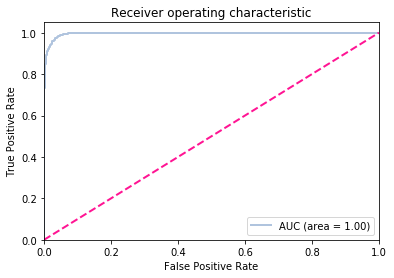

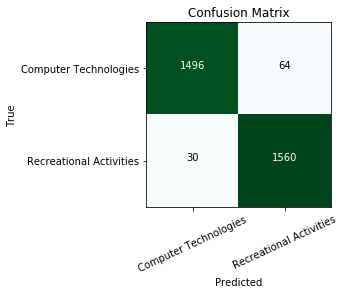

accuracy:  0.970158730159
recall:  0.981132075472
precision:  0.960591133005
----------------------------------------------------------------------
Using LSI and Logistic Regression with penalty: l2


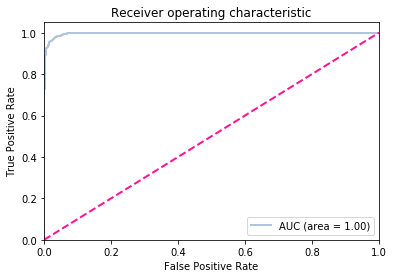

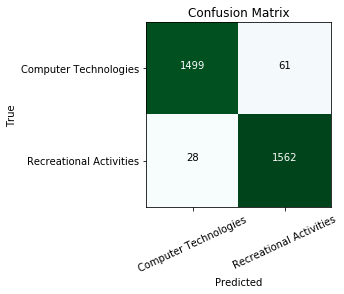

accuracy:  0.971746031746
recall:  0.982389937107
precision:  0.962415280345
----------------------------------------------------------------------
Using NMF and Logistic Regression with penalty: l1


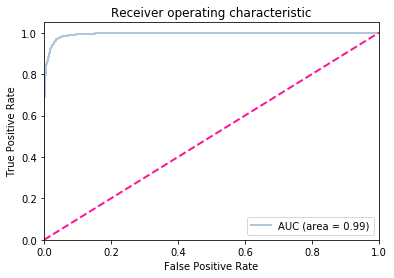

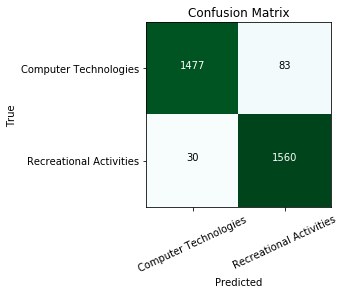

accuracy:  0.964126984127
recall:  0.981132075472
precision:  0.949482653682
----------------------------------------------------------------------
Using NMF and Logistic Regression with penalty: l2


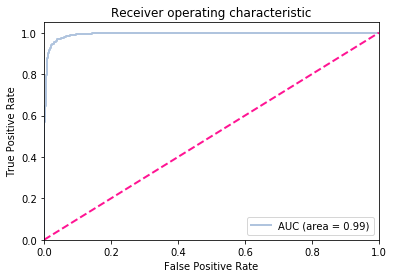

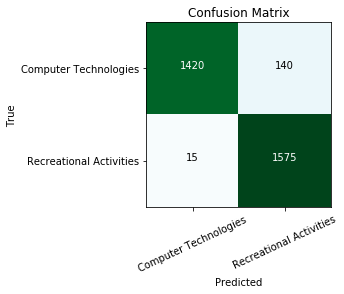

accuracy:  0.950793650794
recall:  0.990566037736
precision:  0.918367346939


In [13]:
logging.info("Problem i")

norm_arr = ["l1", "l2"]

for ai, method in enumerate(method_arr):
    for bi, nm in enumerate(norm_arr):
        pipeline_h = Pipeline([
            ('vect', CountVectorizer(min_df=MIN_DF, stop_words=ENGLISH_STOP_WORDS, tokenizer=stem_and_tokenize)),
            ('tfidf', TfidfTransformer()),
            ('reduce_dim', method),
            ('clf', LogisticRegression(penalty=nm)),
        ])
        pipeline_h.fit(train_data.data, train_label)
        pred_test = pipeline_h.predict(test_data.data)
        pred_test_prob = pipeline_h.predict_proba(test_data.data)[:, 1]
        print("-" * 70)
        print("Using " + method_name[ai] +
              " and Logistic Regression with penalty: " + nm)
        analyze(test_label, pred_test_prob, pred_test, CAT, 2)

logging.info("finished Problem i")


#### j) Multiclass classification

----------------------------------------------------------------------
Using LSI and Learning algorithm: GaussianNaiveBayes


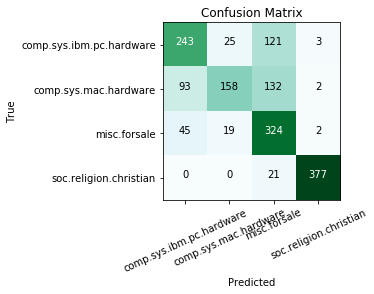

accuracy:  0.704153354633
recall:  0.704153354633
precision:  0.736871246892
----------------------------------------------------------------------
Using LSI and Learning algorithm: OneVsOne(svm)


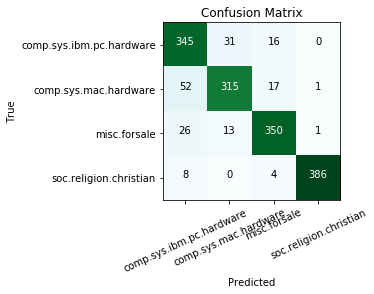

accuracy:  0.892012779553
recall:  0.892012779553
precision:  0.8947328466
----------------------------------------------------------------------
Using LSI and Learning algorithm: OneVsRest(svm)


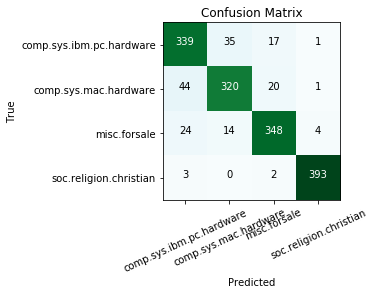

accuracy:  0.894568690096
recall:  0.894568690096
precision:  0.895019248522
----------------------------------------------------------------------
Using NMF and Learning algorithm: GaussianNaiveBayes


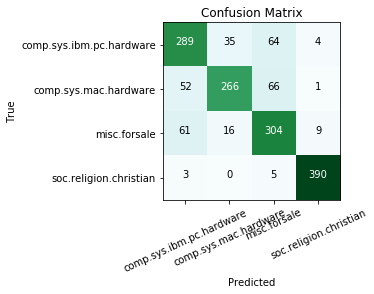

accuracy:  0.798083067093
recall:  0.798083067093
precision:  0.80323300423
----------------------------------------------------------------------
Using NMF and Learning algorithm: OneVsOne(svm)


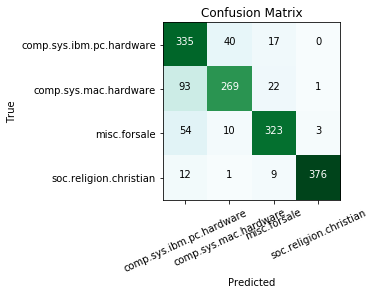

accuracy:  0.832587859425
recall:  0.832587859425
precision:  0.845254242687
----------------------------------------------------------------------
Using NMF and Learning algorithm: OneVsRest(svm)


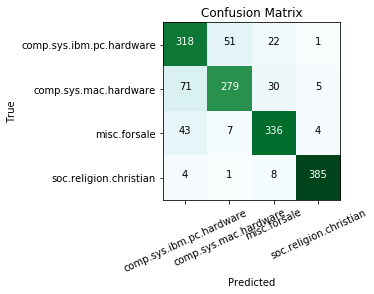

accuracy:  0.842172523962
recall:  0.842172523962
precision:  0.845071729336


In [20]:
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

logging.info("Problem j")

train_mult_data = fetch_20newsgroups(subset='train', categories=cat_top10, shuffle=True, random_state=42)
test_mult_data = fetch_20newsgroups(subset='test', categories=cat_top10, shuffle=True, random_state=42)

clf_arr = [GaussianNB(),
           OneVsOneClassifier(LinearSVC()),
           OneVsRestClassifier(LinearSVC())]
clf_name = ["GaussianNaiveBayes", "OneVsOne(svm)", "OneVsRest(svm)"]

for ai, method in enumerate(method_arr):
    for bi, clf in enumerate(clf_arr):
        pipeline_j = Pipeline([
            ('vect', CountVectorizer(min_df=MIN_DF, stop_words=ENGLISH_STOP_WORDS, tokenizer=stem_and_tokenize)),
            ('tfidf', TfidfTransformer()),
            ('reduce_dim', method),
            ('clf', clf),
        ])
        pipeline_j.fit(train_mult_data.data, train_mult_data.target)
        pred_test = pipeline_j.predict(test_mult_data.data)
        pred_test_prob = []
        print("-" * 70)
        print("Using " + method_name[ai] +
              " and Learning algorithm: " + clf_name[bi])
        analyze(test_mult_data.target, pred_test_prob, pred_test, cat_top10, len(cat_top10))

logging.info("finished Problem j")
